## Transaction Data로부터 파생변수(Feature) 만들기
- input : transactions.csv (트랜잭션 형식의 판매 데이터)
- output : features.csv (머신러닝 모델링이 가능한 형태의 고객 feature 데이터, 일명 Customer Signature)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

font_manager.get_fontconfig_fonts()
font_location = "c:/windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [5]:
data = pd.read_csv('./data/transactions.csv', encoding='cp949')
data.head()

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000


In [6]:
# 파생변수를 저장할 빈 리스트
features = []

### Numeric Features

**[파생변수 1-4]** 총구매액, 구매건수, 평균구매액, 최대구매액

In [7]:
f = data.groupby('cust_id')['amount'].agg([
    ('총구매액', np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features.append(f); f

,cust_id,총구매액,구매건수,평균구매액,최대구매액
0,0,68282840,74,922741.0,11264000
1,1,2136000,3,712000.0,2136000
2,2,3197000,4,799250.0,1639000
3,3,16077620,44,365400.0,4935000
4,4,29050000,3,9683333.0,24000000
...,...,...,...,...,...
3495,3495,3175200,2,1587600.0,3042900
3496,3496,29628600,13,2279123.0,7200000
3497,3497,75000,1,75000.0,75000
3498,3498,1875000,2,937500.0,1000000


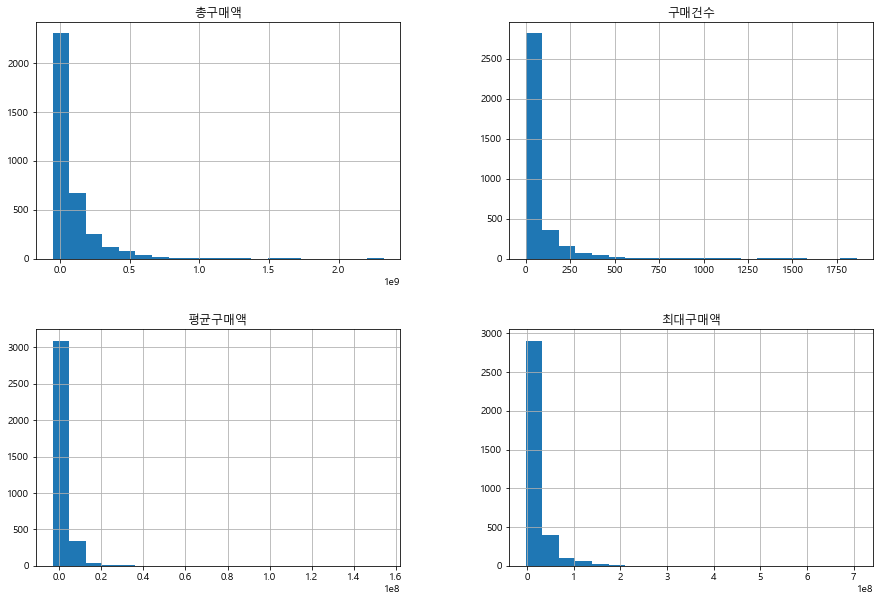

In [8]:
f.drop('cust_id', axis=1).hist(bins=20, figsize=(15,10))
plt.show()

**[파생변수 5-7]** 구매상품종류(goods_id, gds_grp_nm, gds_grp_mclas_nm 각각)

In [13]:
f = data.groupby('cust_id').agg({
    'goods_id': [('구매상품종류1', lambda x: x.nunique())],
    'gds_grp_nm': [('구매상품종류2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('구매상품종류3', lambda x: x.nunique())]
})

print('before drop level:', f.columns)
f.columns = f.columns.droplevel()  
# 동일한 코드: f.columns = [j for _, j in f.columns]
f = f.reset_index()
features.append(f); f

before drop level: MultiIndex([(        'goods_id', '구매상품종류1'),
            (      'gds_grp_nm', '구매상품종류2'),
            ('gds_grp_mclas_nm', '구매상품종류3')],
           )


,cust_id,구매상품종류1,구매상품종류2,구매상품종류3
0,0,35,28,17
1,1,2,2,2
2,2,1,2,2
3,3,24,20,13
4,4,2,3,3
...,...,...,...,...
3495,3495,1,2,2
3496,3496,9,7,5
3497,3497,1,1,1
3498,3498,1,1,1


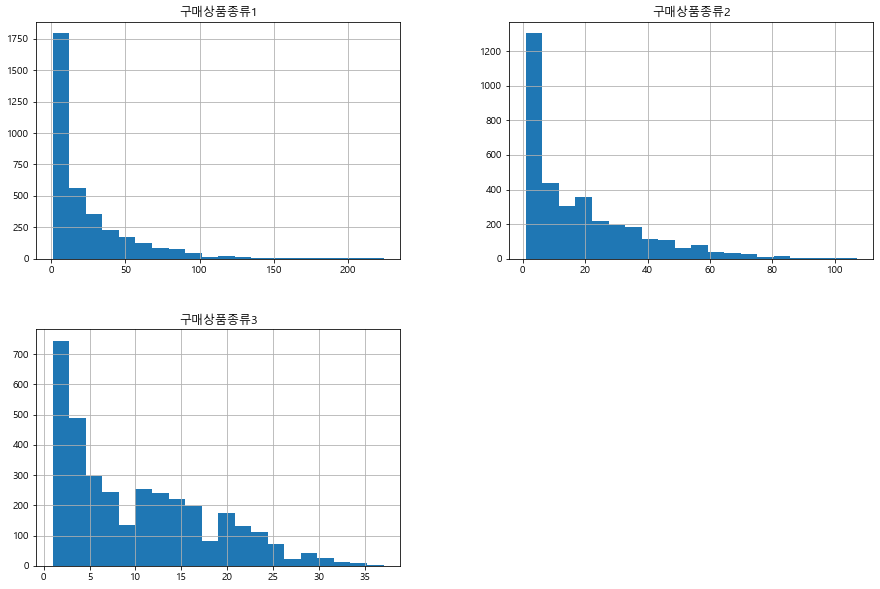

In [14]:
f.drop('cust_id', axis=1).hist(bins=20, figsize=(15,10))
plt.show()